#Lagrangian Data Regularization (LDR)

Este notebook apresenta a técnica Lagrangian Data Regularization (LDR), uma abordagem variacional inspirada na mecânica lagrangiana. A ideia central é tratar cada ponto de dados como uma partícula seguindo uma trajetória, permitindo que a regularização seja formulada como uma minimização da “ação” do dataset — definida como o balanço entre um termo cinético (suavidade dos dados) e um termo potencial (erro do modelo). LDR fornece uma forma alternativa experimental de regularizar datasets ruidosos e investigar sua coerência interna.

Introdução

Em muitos problemas de machine learning, especialmente quando os dados são ruidosos, existe a necessidade de regularizar tanto o modelo quanto o próprio dataset. A mecânica lagrangiana oferece um princípio elegante: sistemas físicos seguem trajetórias que minimizam (ou estacionam) a ação.

Podemos aplicar a mesma ideia aos dados:

T(x) = termo cinético ==> medir a variação entre pontos
V(x) = termo potencial ==> medir a distância do ponto ao modelo

A função Lagrangiana aplicada aos dados é:
L(x)=T(x)−V(x)

E a regularização será minimizar:
S=∑L(x)

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [46]:
def kinetic_term(y):
    #Termo cinético T: mede variação local entre pontos proximos.
    #Quanto mais suave a sequência, menor T.
    return np.sum((np.diff(y))**2)

def potential_term(y, y_pred):
    #Termo potencial V: mede o erro de ajuste do modelo.
    return np.sum((y - y_pred)**2)


In [47]:
def lagrangian_data(y, y_pred, alpha=1.0):
    #L = T - alpha * V
    #alpha controla o peso da fidelidade ao modelo.
    T = kinetic_term(y)
    V = potential_term(y, y_pred)
    return T - alpha * V


In [54]:
# Dados artificiais: Criando um conjunto de dados com uma relação linear (y = 3x + 2) com adição de ruído.
np.random.seed(0)# Garantir reprodutibilidade dos resultados
x = np.linspace(0, 10, 50) # Criando um vetor de 50 valores igualmente espaçados entre 0 e 10
y_true = 3*x + 2 # Relação linear verdadeira (sem ruído)
y = y_true + np.random.normal(0, 4, size=len(x))  # Adicionando ruído gaussiano aos dados
Limitações atuais (unidimensional, linear, dados artificiais)
# Modelo base
model = LinearRegression()
model.fit(x.reshape(-1,1), y)
y_pred = model.predict(x.reshape(-1,1))
mse_raw = mean_squared_error(y, y_pred)

# Calculando a Lagrangiana com o modelo ajustado
L = lagrangian_data(y, y_pred)

print("Valor da Lagrangiana dos dados:", L)

Valor da Lagrangiana dos dados: 953.283266806209


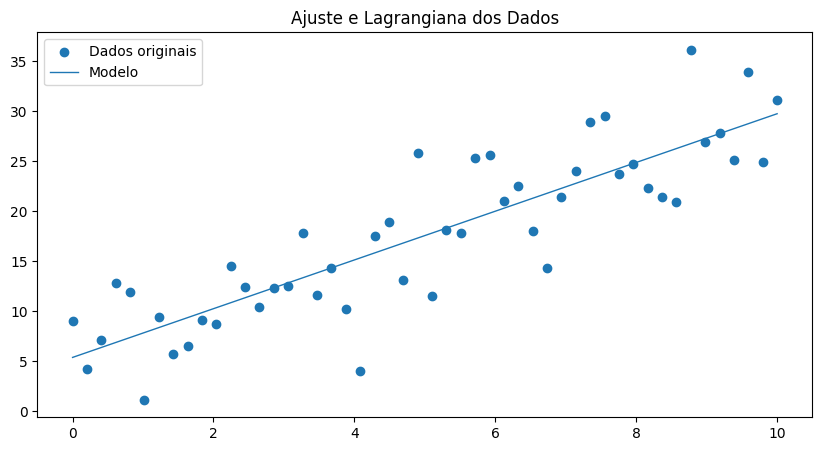

In [10]:
plt.figure(figsize=(10,5))
plt.scatter(x, y, label="Dados originais")  # Plotando os dados com ruído (dados originais)
plt.plot(x, y_pred, label="Modelo", linewidth=1)
plt.legend()
plt.title("Ajuste e Lagrangiana dos Dados")
plt.show()


####Segue agora um modelo utilizando a LDR para visualizarmos como o metodo melhora a coerência interna dos dados resultando numa redução significativa da função de custo.

In [56]:
# Aplicando LDR nos dados
def lagrangian_regularization_1d(y, alpha=0.1, iters=50):
    y_smooth = y.copy()
    for _ in range(iters):
        smoothness = np.zeros_like(y_smooth)
        smoothness[1:-1] = y_smooth[:-2] - 2*y_smooth[1:-1] + y_smooth[2:]
        grad = -smoothness + alpha * (y_smooth - np.mean(y_smooth))
        y_smooth -= 0.1 * grad
    return y_smooth

y_ldr = lagrangian_regularization_1d(y)


In [57]:
model_ldr = LinearRegression()
model_ldr.fit(x.reshape(-1,1), y_ldr)
y_pred_ldr = model_ldr.predict(x.reshape(-1,1))


In [58]:
from sklearn.metrics import mean_squared_error

mse_raw = mean_squared_error(y, y_pred)
mse_ldr = mean_squared_error(y_ldr, y_pred_ldr)

print("MSE antes do LDR:", mse_raw)
print("MSE após o LDR:", mse_ldr)


MSE antes do LDR: 17.50348036685026
MSE após o LDR: 0.3518342898385008


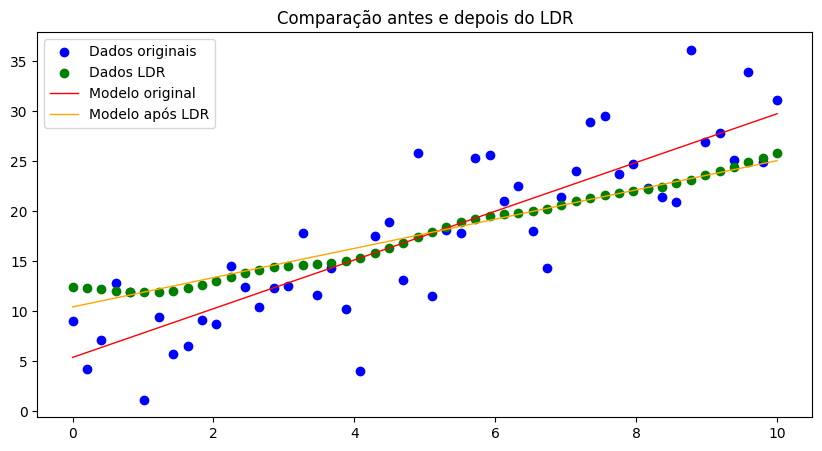

In [59]:
plt.figure(figsize=(10,5))
plt.scatter(x, y, label="Dados originais", color='blue')
plt.scatter(x, y_ldr, label="Dados LDR", color='green')
plt.plot(x, y_pred, label="Modelo original", color='red', linewidth=1)
plt.plot(x, y_pred_ldr, label="Modelo após LDR", color='orange', linewidth=1)
plt.legend()
plt.title("Comparação antes e depois do LDR")
plt.show()


##Interpretação do LDR

Se os dados têm muita oscilação ==> T aumenta

Se o modelo está muito errado ==> V aumenta

A LDR busca o equilíbrio:
uma trajetória de dados suave que ainda respeita o modelo.

É como tratar o dataset como se tivesse uma “dinâmica física”.



Este método pode ajudar a mitigar não-diferenciabilidade causada por outliers, reduzindo sua ação e realocando pontos para posições energeticamente mais estáveis em espaços unidimensionais.

Mesmo em sua forma inicial e utilizando dados sinteticos, o LDR mostrou capacidade real de:

reduzir a influência de outliers;

estabilizar a geometria dos dados;

e fornecer uma nova perspectiva sobre regularização baseada em energia.

Apesar de ainda ser um método experimental, o LDR demonstra potencial significativo para evoluir em diversas direções: versões multivariadas completas, integração com autograd, otimização em GPU e muitas outras.

Como projeto open source, o LDR não é apresentado como uma solução final, mas como um ponto de partida. Uma semente conceitual que pode crescer com teste, crítica, refinamento e colaboração.

Convido a comunidade (pesquisadores, estudantes e profissionais) a explorar, propor melhorias, sugerir novas Lagrangianas, testar em aplicações reais e expandir esta abordagem. O LDR foi criado para ser um projeto aberto, vivo e em evolução.

Se esta ideia provocar novas perguntas, novos métodos ou novas discussões, ela já terá cumprido seu propósito.

#Referências:
1.Aurélin Géron: Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build intelligent Systems.2° edição, O'Reilly Media, 2019.

2.IBM: AI Engineering Professional Certificate. Curso online disponivel ma plataforma IBM SkillsBuild/Coursera

3.Professor Sérgio de Sá. Aulas de Mecânica Lagrangiana (YouTube)